In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import sentencepiece
from langchain_ollama import ChatOllama
from langchain.schema import HumanMessage



In [14]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [48]:
# Load the fine-tuned model and tokenizer
path1 = "../glue_mrpc_bert_model"  # Path to the saved fine-tuned model
 # Path to the saved tokenizer
model1 = AutoModelForSequenceClassification.from_pretrained(path1).to(device)
tokenizer1 = AutoTokenizer.from_pretrained(path1)

In [11]:
dataset = load_dataset("glue", "mrpc")

In [14]:
def preprocess_function(examples):
    # Tokenize the sentence pairs for BERT
    return tokenizer2(
        examples['sentence1'], 
        examples['sentence2'], 
        truncation=True, 
        padding="max_length", 
        max_length=128
    )

In [15]:
tokenized_test_dataset = dataset['test'].map(preprocess_function, batched=True)

Map: 100%|██████████| 1725/1725 [00:00<00:00, 20513.97 examples/s]


In [52]:
trainer = Trainer(
    model=model1,
    tokenizer=tokenizer1
)

In [53]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Equivalent", "Equivalent"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

In [54]:
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [55]:
predictions = trainer.predict(tokenized_test_dataset)

# Extract logits and predicted labels
logits = predictions.predictions
y_pred = np.argmax(logits, axis=-1)

# Extract true labels from the test set
labels = np.array(tokenized_test_dataset["label"])

100%|██████████| 216/216 [00:09<00:00, 23.89it/s]


In [56]:
class_report = classification_report(labels, y_pred, target_names=["Not Equivalent", "Equivalent"])
print("Classification Report:")
print(class_report)

Classification Report:
                precision    recall  f1-score   support

Not Equivalent       0.81      0.64      0.72       578
    Equivalent       0.84      0.92      0.88      1147

      accuracy                           0.83      1725
     macro avg       0.82      0.78      0.80      1725
  weighted avg       0.83      0.83      0.82      1725



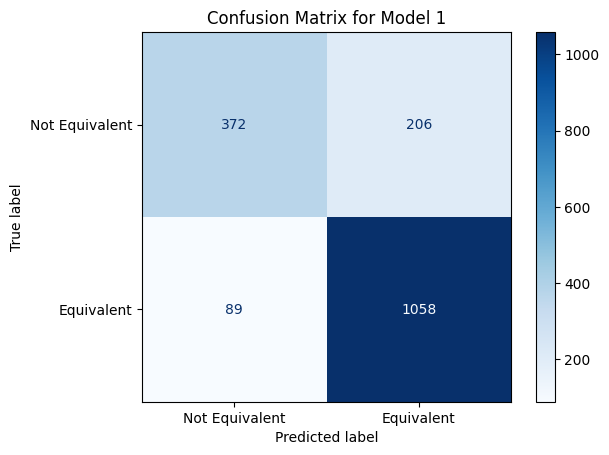

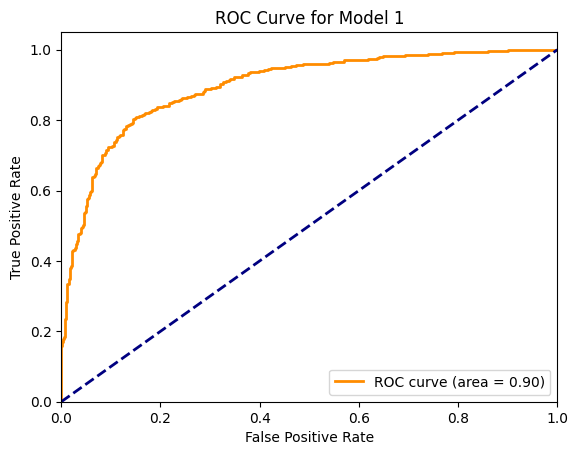

In [57]:
plot_confusion_matrix(labels, y_pred, title="Confusion Matrix for Model 1")
plot_roc_curve(labels, logits[:, 1], title="ROC Curve for Model 1")

In [58]:
path2 = "../glue_mrpc_softprompt_bert_model"


# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(path2).to(device)
tokenizer = AutoTokenizer.from_pretrained(path2)

In [59]:
tokenized_test_dataset1 = dataset['test'].map(preprocess_function, batched=True)

In [36]:
tokenized_test_dataset1.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [60]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer
)

# Predict the labels for the test set
predictions = trainer.predict(tokenized_test_dataset1)

# Extract logits and predicted labels
logits = predictions.predictions
y_pred = np.argmax(logits, axis=-1)

# Extract true labels from the test set
labels = np.array(tokenized_test_dataset["label"])

100%|██████████| 216/216 [00:08<00:00, 24.07it/s]


In [61]:
# Generate classification report
class_report = classification_report(labels, y_pred, target_names=["Not Equivalent", "Equivalent"])
print("Classification Report:")
print(class_report)


Classification Report:
                precision    recall  f1-score   support

Not Equivalent       0.81      0.41      0.54       578
    Equivalent       0.76      0.95      0.85      1147

      accuracy                           0.77      1725
     macro avg       0.78      0.68      0.69      1725
  weighted avg       0.78      0.77      0.74      1725



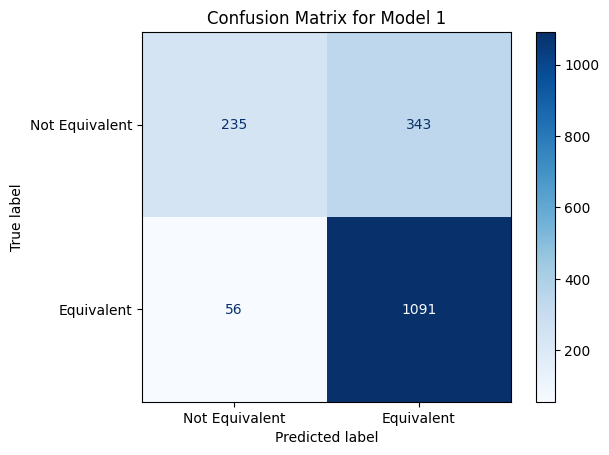

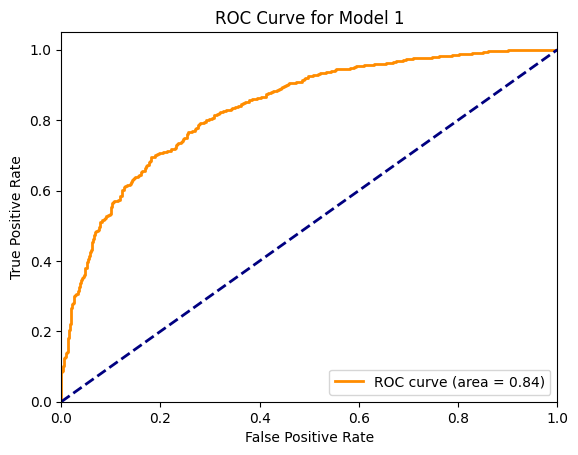

In [62]:
plot_confusion_matrix(labels, y_pred, title="Confusion Matrix for Model 1")
plot_roc_curve(labels, logits[:, 1], title="ROC Curve for Model 1")

In [6]:
device='mps'

In [7]:
# Load the fine-tuned model and tokenizer
path2 = "../glue_mrpc_softprompt_bert_model"  # Path to the saved fine-tuned model
 # Path to the saved tokenizer
model2 = AutoModelForSequenceClassification.from_pretrained(path2).to(device)
tokenizer2 = AutoTokenizer.from_pretrained(path2)

In [16]:
tokenized_test_dataset1 = dataset['test'].map(preprocess_function, batched=True)
tokenized_test_dataset1.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [17]:
trainer = Trainer(
    model=model2,
    tokenizer=tokenizer2
)

# Predict the labels for the test set
predictions = trainer.predict(tokenized_test_dataset1)



100%|██████████| 216/216 [00:08<00:00, 24.57it/s]


In [18]:
# Extract logits and predicted labels
logits = predictions.predictions
y_pred = np.argmax(logits, axis=-1)

# Extract true labels from the test set
labels = np.array(tokenized_test_dataset["label"])

In [19]:
# Generate classification report
class_report = classification_report(labels, y_pred, target_names=["Not Equivalent", "Equivalent"])
print("Classification Report:")
print(class_report)



Classification Report:
                precision    recall  f1-score   support

Not Equivalent       0.69      0.61      0.65       578
    Equivalent       0.81      0.86      0.84      1147

      accuracy                           0.78      1725
     macro avg       0.75      0.74      0.74      1725
  weighted avg       0.77      0.78      0.77      1725



In [21]:
model3 = ChatOllama(model="llama3.1", temperature=0.0,device='mps')

In [22]:
def add_hard_prompts(sentence1, sentence2):
    """
    This function adds a hard prompt to each input example
    to make the task explicit to the model.
    """
    prompt = f"""Paraphrase detection: Does the following pair of sentences mean the same thing? Sentence 1: "{sentence1}" Sentence 2: "{sentence2}". Reply with a single word answer: 'yes' if they mean the same thing, otherwise 'no'."""
    return prompt

In [23]:
validation_prompts = [add_hard_prompts(sent1, sent2) for sent1, sent2 in zip(dataset["validation"]["sentence1"], dataset["validation"]["sentence2"])]

In [24]:
out=[]

In [25]:
def llama_inference(prompts, model):
    """
    This function uses LLaMA 3.1 model for inference on hard-prompted inputs.
    """
    predictions = []
    for prompt in prompts:
        # Convert prompt to HumanMessage
        human_message = HumanMessage(content=prompt)
        
        # Query the LLaMA 3.1 model using __call__
        response = model([human_message])

        
        # Extract the response text (response is already an AIMessage object)
        prediction = response.content.strip().lower()
        out.append(prediction)
        # Convert textual output to binary labels
        if "yes" in prediction:
            predictions.append(1)  # Paraphrase
        else:
            predictions.append(0)  # Not a paraphrase
            
    return predictions


In [27]:
predictions = llama_inference(validation_prompts, model3)

/var/folders/n_/4p37f261177fmjpv4kt7x33m0000gn/T/ipykernel_53428/3396255699.py:11: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  response = model([human_message])


In [28]:
from sklearn.metrics import classification_report, accuracy_score

# Get true labels from the validation set
true_labels = dataset["validation"]["label"]

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions))

# Print overall accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Validation Accuracy with Hard Prompts: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.43      0.51       129
           1       0.77      0.87      0.82       279

    accuracy                           0.73       408
   macro avg       0.69      0.65      0.66       408
weighted avg       0.72      0.73      0.72       408

Validation Accuracy with Hard Prompts: 0.7328
